In [ ]:
#SAMIRA BAGHBANBARI, ID: 1009220497
#LINK TO NOTEBOOK : https://colab.research.google.com/drive/1CPBZpK4X0QOklz24hUrrsFH5V2X-i_r8?usp=sharing#scrollTo=XKgszkTRnuUE

In [ ]:
# importing libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

In [ ]:
# importing data
file_path = '/content/Indian_liver_patient_assignment_1.csv'
data = pd.read_csv(filepath_or_buffer=file_path)
data = data.fillna(0)
data.loc[data['Gender'] == 'Female', 'Gender'] = 1
data.loc[data['Gender'] == 'Male', 'Gender'] = 0
data.loc[data['Dataset'] == 2, 'Dataset'] = 0 # changing 2 (healthy) to 0

In [ ]:
# defining features and label arrays
features = np.array(data)[:,range(10)].astype(float)
labels = np.array(data)[:,-1].astype(float)
group = np.array(data).astype(float)

3. Data Preparation

In [ ]:
# Split data into train and test sets without normalization
X_train, X_test, y_train, y_test, group_train, group_test = sklearn.model_selection.train_test_split(features,
                                                                            labels, group, test_size=0.3,
                                                                            train_size=0.7, shuffle = True,
                                                                            random_state=42)

# Split data into train and test sets with normalization
scaler = StandardScaler()
scaler.fit(features)
features_normalized = scaler.transform(features)
X_train_norm, X_test_norm, y_train_norm, y_test_norm, group_train_norm, group_test_norm = sklearn.model_selection.train_test_split(features_normalized,
                                                                            labels, group, test_size=0.3,
                                                                            train_size=0.7, shuffle = True,
                                                                            random_state=42)

# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

batch_size = 64

train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
##
train_data_norm = Data(X_train_norm, y_train_norm)
train_dataloader_norm = DataLoader(dataset=train_data_norm, batch_size=batch_size, shuffle=True)
test_data_norm = Data(X_test_norm, y_test_norm)
test_dataloader_norm = DataLoader(dataset=test_data_norm, batch_size=batch_size, shuffle=True)



4. Model

In [ ]:
# simple multi-layer perceptron
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        in_size = input_size
        for out_size in hidden_sizes:
            self.layers.append(nn.Linear(in_size, out_size))
            self.layers.append(nn.ReLU()) # Relu for hidden layers
            in_size = out_size
        self.layers.append(nn.Linear(in_size, output_size))
        self.sigmoid = nn.Sigmoid() # Sigmoid for output layer

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.sigmoid(x)
        return x

5. part a ) train and evaluate the model with not normalized dataset (In 4 trials)

Final Training Accuracy: 0.7656
Final Testing Accuracy: 0.7447
Final Training F1 Score: 0.8649
Final Testing F1 Score: 0.8421


Text(0, 0.5, 'F1_score')

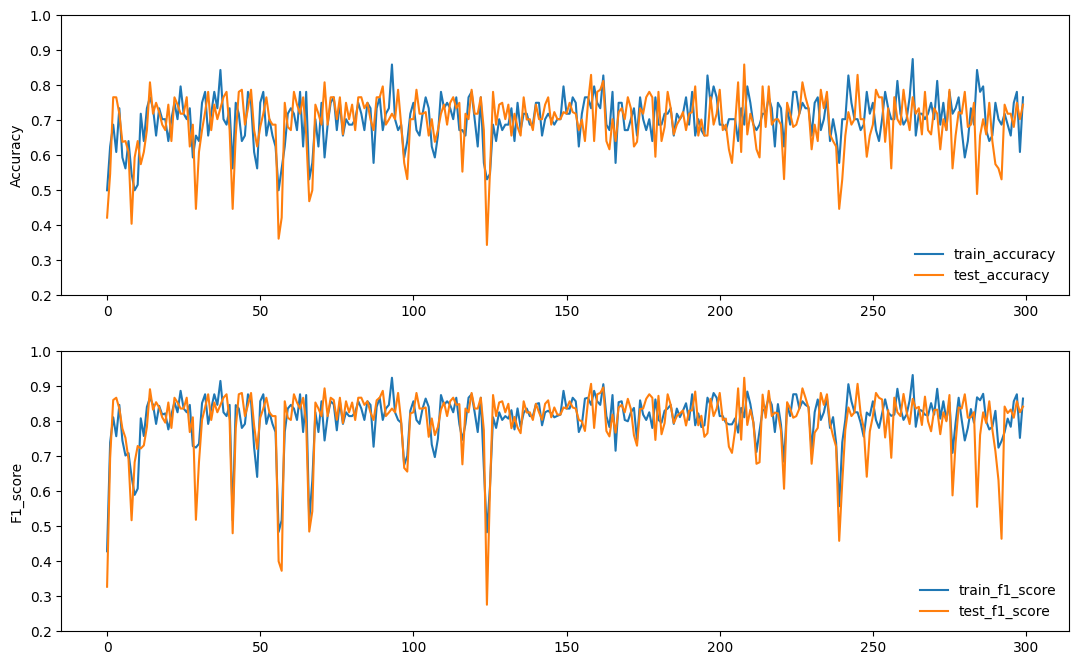

In [ ]:
input_size = 10  # feature dimension
hidden_layer_sizes = [64, 32]  # List of hidden layer sizes
output_size = 1  # binary classification

model = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

## training the model
train_accuracy_values = []
test_accuracy_values = []
train_f1_values = []
test_f1_values = []

num_epochs = 100
for epoch in range(num_epochs):
    for (X_train, y_train), (X_test, y_test) in zip(train_dataloader, test_dataloader):
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss = criterion(pred_train, y_train.unsqueeze(-1)) # compute loss
        loss.backward()
        optimizer.step()

        # compute training accuracy and F1-score at this epoch
        pred_train = (model(X_train) > 0.5).float()
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1 = f1_score(y_train, pred_train)
        train_accuracy_values.append(train_accuracy)
        train_f1_values.append(train_f1)

        # compute testing accuracy and F1-score at this epoch
        pred_test = (model(X_test) > 0.5).float()
        test_accuracy = accuracy_score(y_test, pred_test)
        test_f1 = f1_score(y_test, pred_test)
        test_accuracy_values.append(test_accuracy)
        test_f1_values.append(test_f1)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training F1 Score: {train_f1:.4f}")
print(f"Final Testing F1 Score: {test_f1:.4f}")

# plotting training and test performances over epochs
fig, axs = plt.subplots(2, 1, figsize=(13,8))
axs[0].plot(train_accuracy_values, label='train_accuracy')
axs[0].plot(test_accuracy_values, label='test_accuracy')
axs[0].legend(frameon=False, loc='lower right')
axs[0].set_ylim([0.2, 1])
axs[0].set_ylabel('Accuracy')
###
axs[1].plot(train_f1_values, label='train_f1_score')
axs[1].plot(test_f1_values, label='test_f1_score')
axs[1].legend(frameon=False, loc='lower right')
axs[1].set_ylim([0.2, 1])
axs[1].set_ylabel('F1_score')

Final Training Accuracy: 0.6875
Final Testing Accuracy: 0.6809
Final Training F1 Score: 0.8113
Final Testing F1 Score: 0.8101


Text(0, 0.5, 'F1_score')

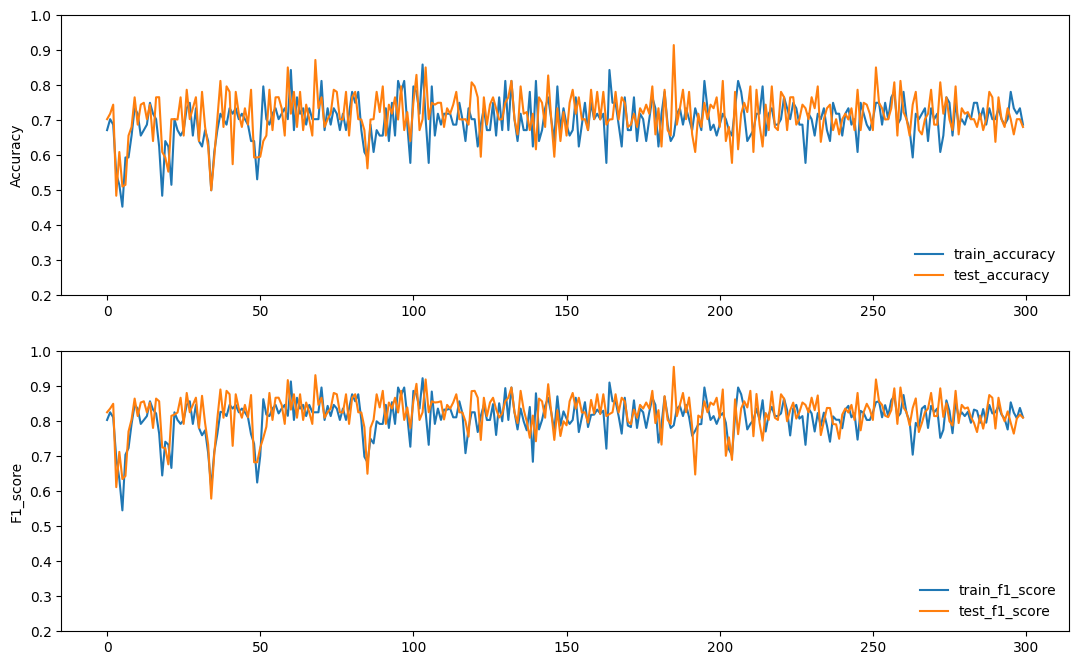

In [ ]:
input_size = 10  # feature dimension
hidden_layer_sizes = [32, 32]  # List of hidden layer sizes
output_size = 1  # binary classification

model = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

## training the model
train_accuracy_values = []
test_accuracy_values = []
train_f1_values = []
test_f1_values = []

num_epochs = 100
for epoch in range(num_epochs):
    for (X_train, y_train), (X_test, y_test) in zip(train_dataloader, test_dataloader):
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss = criterion(pred_train, y_train.unsqueeze(-1)) # compute loss
        loss.backward()
        optimizer.step()

        # compute training accuracy and F1-score at this epoch
        pred_train = (model(X_train) > 0.5).float()
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1 = f1_score(y_train, pred_train)
        train_accuracy_values.append(train_accuracy)
        train_f1_values.append(train_f1)

        # compute testing accuracy and F1-score at this epoch
        pred_test = (model(X_test) > 0.5).float()
        test_accuracy = accuracy_score(y_test, pred_test)
        test_f1 = f1_score(y_test, pred_test)
        test_accuracy_values.append(test_accuracy)
        test_f1_values.append(test_f1)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training F1 Score: {train_f1:.4f}")
print(f"Final Testing F1 Score: {test_f1:.4f}")

# plotting training and test performances over epochs
fig, axs = plt.subplots(2, 1, figsize=(13,8))
axs[0].plot(train_accuracy_values, label='train_accuracy')
axs[0].plot(test_accuracy_values, label='test_accuracy')
axs[0].legend(frameon=False, loc='lower right')
axs[0].set_ylim([0.2, 1])
axs[0].set_ylabel('Accuracy')
###
axs[1].plot(train_f1_values, label='train_f1_score')
axs[1].plot(test_f1_values, label='test_f1_score')
axs[1].legend(frameon=False, loc='lower right')
axs[1].set_ylim([0.2, 1])
axs[1].set_ylabel('F1_score')

Final Training Accuracy: 0.7188
Final Testing Accuracy: 0.6809
Final Training F1 Score: 0.8235
Final Testing F1 Score: 0.7887


Text(0, 0.5, 'F1_score')

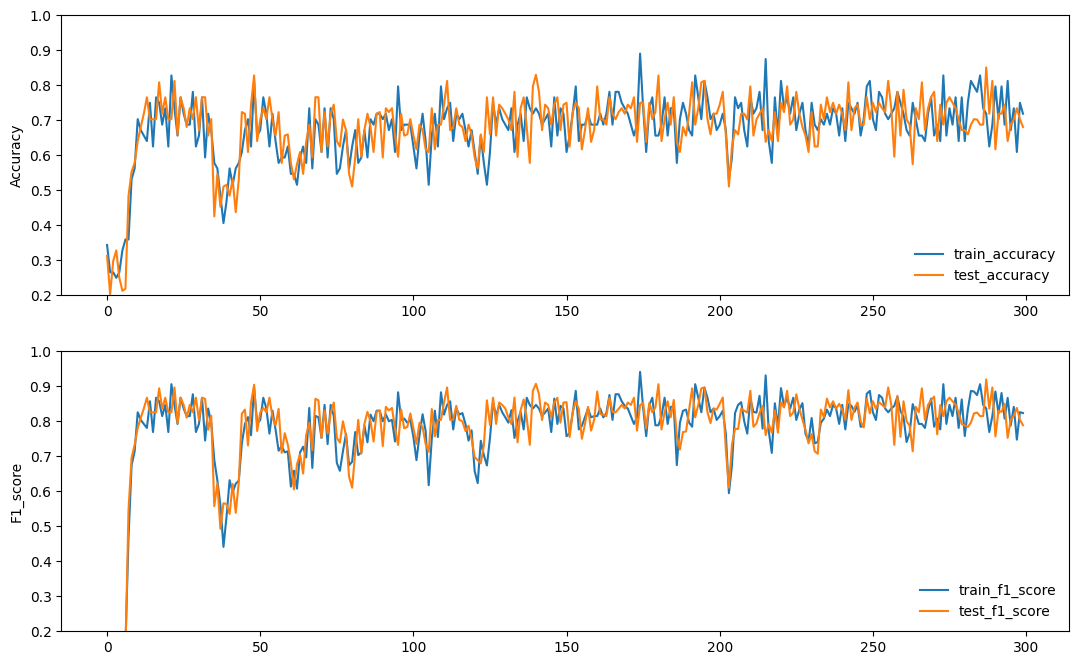

In [ ]:
input_size = 10  # feature dimension
hidden_layer_sizes = [64]  # List of hidden layer sizes
output_size = 1  # binary classification

model = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

## training the model
train_accuracy_values = []
test_accuracy_values = []
train_f1_values = []
test_f1_values = []

num_epochs = 100
for epoch in range(num_epochs):
    for (X_train, y_train), (X_test, y_test) in zip(train_dataloader, test_dataloader):
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss = criterion(pred_train, y_train.unsqueeze(-1)) # compute loss
        loss.backward()
        optimizer.step()

        # compute training accuracy and F1-score at this epoch
        pred_train = (model(X_train) > 0.5).float()
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1 = f1_score(y_train, pred_train)
        train_accuracy_values.append(train_accuracy)
        train_f1_values.append(train_f1)

        # compute testing accuracy and F1-score at this epoch
        pred_test = (model(X_test) > 0.5).float()
        test_accuracy = accuracy_score(y_test, pred_test)
        test_f1 = f1_score(y_test, pred_test)
        test_accuracy_values.append(test_accuracy)
        test_f1_values.append(test_f1)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training F1 Score: {train_f1:.4f}")
print(f"Final Testing F1 Score: {test_f1:.4f}")

# plotting training and test performances over epochs
fig, axs = plt.subplots(2, 1, figsize=(13,8))
axs[0].plot(train_accuracy_values, label='train_accuracy')
axs[0].plot(test_accuracy_values, label='test_accuracy')
axs[0].legend(frameon=False, loc='lower right')
axs[0].set_ylim([0.2, 1])
axs[0].set_ylabel('Accuracy')
###
axs[1].plot(train_f1_values, label='train_f1_score')
axs[1].plot(test_f1_values, label='test_f1_score')
axs[1].legend(frameon=False, loc='lower right')
axs[1].set_ylim([0.2, 1])
axs[1].set_ylabel('F1_score')

Final Training Accuracy: 0.6875
Final Testing Accuracy: 0.5745
Final Training F1 Score: 0.7826
Final Testing F1 Score: 0.6970


Text(0, 0.5, 'F1_score')

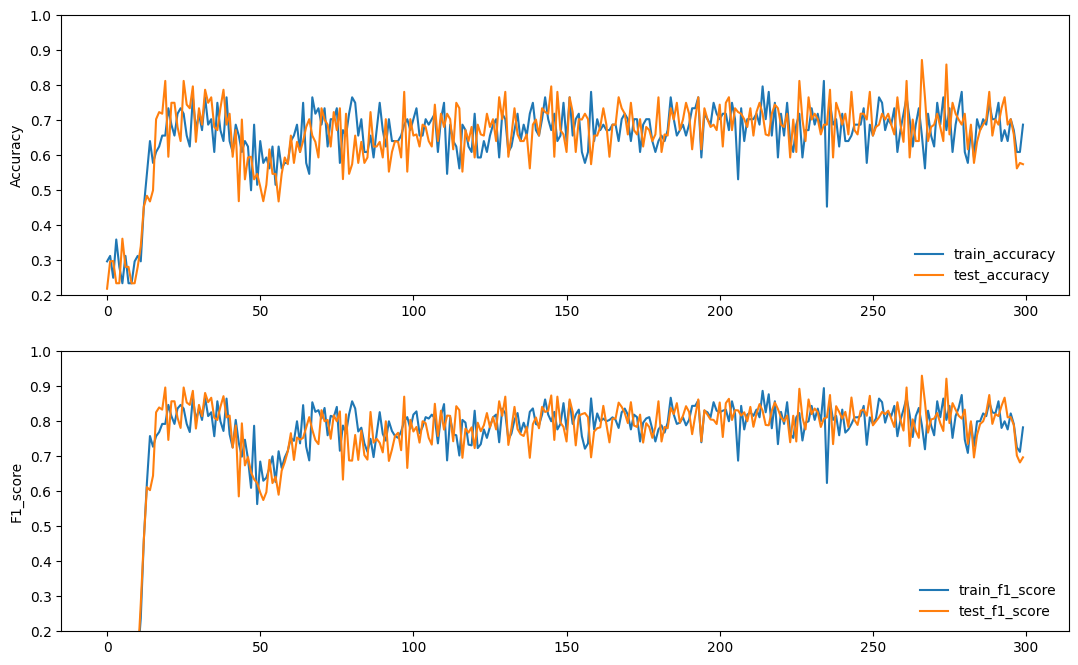

In [ ]:
input_size = 10  # feature dimension
hidden_layer_sizes = [32]  # List of hidden layer sizes
output_size = 1  # binary classification

model = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

## training the model
train_accuracy_values = []
test_accuracy_values = []
train_f1_values = []
test_f1_values = []

num_epochs = 100
for epoch in range(num_epochs):
    for (X_train, y_train), (X_test, y_test) in zip(train_dataloader, test_dataloader):
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss = criterion(pred_train, y_train.unsqueeze(-1)) # compute loss
        loss.backward()
        optimizer.step()

        # compute training accuracy and F1-score at this epoch
        pred_train = (model(X_train) > 0.5).float()
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1 = f1_score(y_train, pred_train)
        train_accuracy_values.append(train_accuracy)
        train_f1_values.append(train_f1)

        # compute testing accuracy and F1-score at this epoch
        pred_test = (model(X_test) > 0.5).float()
        test_accuracy = accuracy_score(y_test, pred_test)
        test_f1 = f1_score(y_test, pred_test)
        test_accuracy_values.append(test_accuracy)
        test_f1_values.append(test_f1)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training F1 Score: {train_f1:.4f}")
print(f"Final Testing F1 Score: {test_f1:.4f}")

# plotting training and test performances over epochs
fig, axs = plt.subplots(2, 1, figsize=(13,8))
axs[0].plot(train_accuracy_values, label='train_accuracy')
axs[0].plot(test_accuracy_values, label='test_accuracy')
axs[0].legend(frameon=False, loc='lower right')
axs[0].set_ylim([0.2, 1])
axs[0].set_ylabel('Accuracy')
###
axs[1].plot(train_f1_values, label='train_f1_score')
axs[1].plot(test_f1_values, label='test_f1_score')
axs[1].legend(frameon=False, loc='lower right')
axs[1].set_ylim([0.2, 1])
axs[1].set_ylabel('F1_score')

comparing the training and testing accuracies in 4 trials of [64,32], [32,32], [64], [32] , shows the model with 2 layers and 64 and 32 nodes has the highest training and testing accuracy so the [64,32] works better with this NN algorithm. And the greater numner of layers and nodes doesnt necessarily increase the trainung and testing accuracy due to simplicity of the model it doesnt need to incorporate multiple hidden layers, even one layer would suffice.

5.b Check the model with Standardized dataset

Final Training Accuracy: 0.7031
Final Testing Accuracy: 0.7872
Final Training F1 Score: 0.8257
Final Testing F1 Score: 0.8810


Text(0, 0.5, 'F1_score')

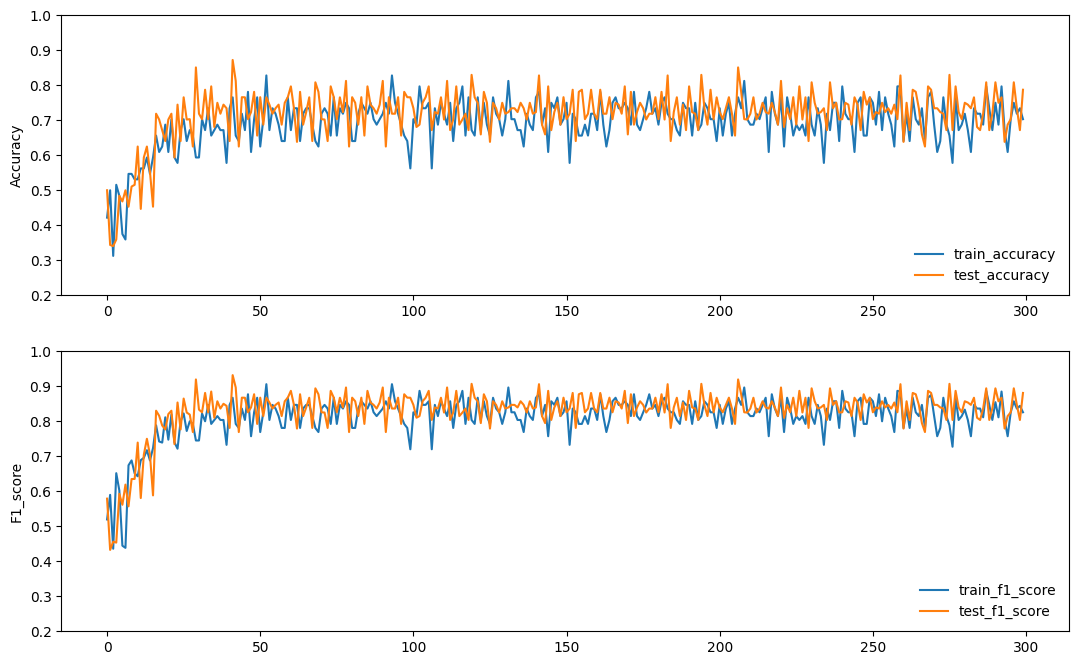

In [ ]:
model = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

## training the model
train_accuracy_values = []
test_accuracy_values = []
train_f1_values = []
test_f1_values = []

num_epochs = 100
for epoch in range(num_epochs):
    for (X_train, y_train), (X_test, y_test) in zip(train_dataloader_norm, test_dataloader_norm):
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss = criterion(pred_train, y_train.unsqueeze(-1)) # compute loss
        loss.backward()
        optimizer.step()

        # compute training accuracy and F1-score at this epoch
        pred_train = (model(X_train) > 0.5).float()
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1 = f1_score(y_train, pred_train)
        train_accuracy_values.append(train_accuracy)
        train_f1_values.append(train_f1)

        # compute testing accuracy and F1-score at this epoch
        pred_test = (model(X_test) > 0.5).float()
        test_accuracy = accuracy_score(y_test, pred_test)
        test_f1 = f1_score(y_test, pred_test)
        test_accuracy_values.append(test_accuracy)
        test_f1_values.append(test_f1)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training F1 Score: {train_f1:.4f}")
print(f"Final Testing F1 Score: {test_f1:.4f}")

# plotting training and test performances over epochs
fig, axs = plt.subplots(2, 1, figsize=(13,8))
axs[0].plot(train_accuracy_values, label='train_accuracy')
axs[0].plot(test_accuracy_values, label='test_accuracy')
axs[0].legend(frameon=False, loc='lower right')
axs[0].set_ylim([0.2, 1])
axs[0].set_ylabel('Accuracy')
###
axs[1].plot(train_f1_values, label='train_f1_score')
axs[1].plot(test_f1_values, label='test_f1_score')
axs[1].legend(frameon=False, loc='lower right')
axs[1].set_ylim([0.2, 1])
axs[1].set_ylabel('F1_score')


The difference between training and testing accuracies of data with normalization and without normalization is negligible; meaning the NN doesnt need normalization, so due the insignificant change in results, i will continue with the original scale.

5.c (1) Continue without normalization (not much effect was seen by normalization)

Final Training Accuracy: 0.6875
Final Testing Accuracy: 0.7447
Final Training F1 Score: 0.8148
Final Testing F1 Score: 0.8537


Text(0, 0.5, 'F1_score')

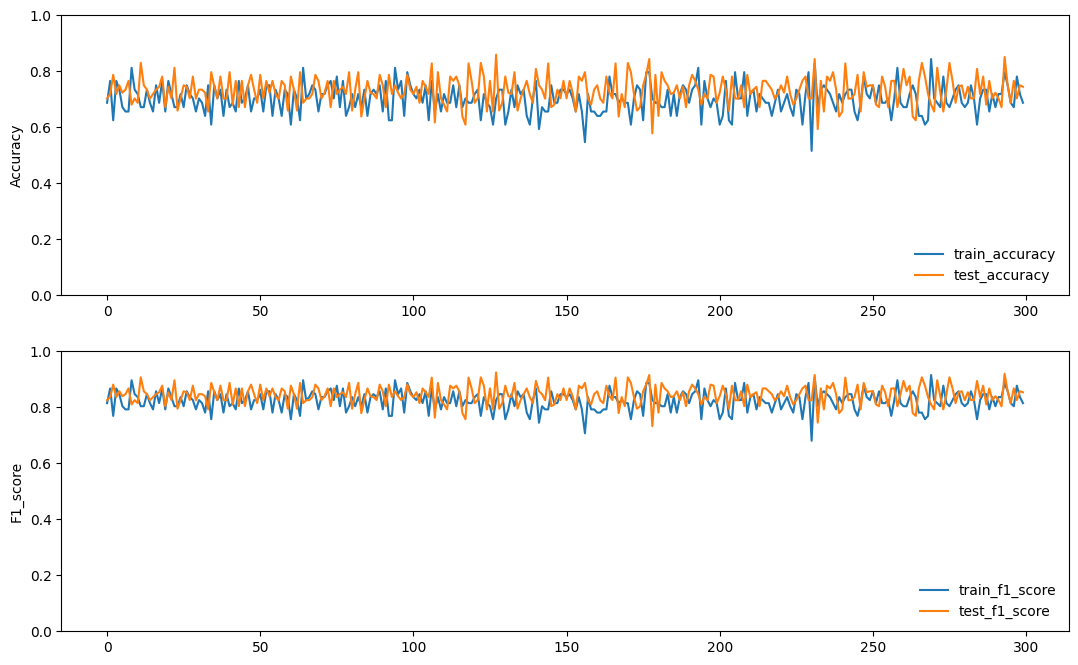

In [ ]:
## changing learning rate (fixed 0.1)

model = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.1) # Adam optimizer

## training the model
train_accuracy_values = []
test_accuracy_values = []
train_f1_values = []
test_f1_values = []

num_epochs = 100
for epoch in range(num_epochs):
    for (X_train, y_train), (X_test, y_test) in zip(train_dataloader, test_dataloader):
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss = criterion(pred_train, y_train.unsqueeze(-1)) # compute loss
        loss.backward()
        optimizer.step()

        # compute training accuracy and F1-score at this epoch
        pred_train = (model(X_train) > 0.5).float()
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1 = f1_score(y_train, pred_train)
        train_accuracy_values.append(train_accuracy)
        train_f1_values.append(train_f1)

        # compute testing accuracy and F1-score at this epoch
        pred_test = (model(X_test) > 0.5).float()
        test_accuracy = accuracy_score(y_test, pred_test)
        test_f1 = f1_score(y_test, pred_test)
        test_accuracy_values.append(test_accuracy)
        test_f1_values.append(test_f1)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training F1 Score: {train_f1:.4f}")
print(f"Final Testing F1 Score: {test_f1:.4f}")

# plotting training and test performances over epochs
fig, axs = plt.subplots(2, 1, figsize=(13,8))
axs[0].plot(train_accuracy_values, label='train_accuracy')
axs[0].plot(test_accuracy_values, label='test_accuracy')
axs[0].legend(frameon=False, loc='lower right')
axs[0].set_ylim([0, 1])
axs[0].set_ylabel('Accuracy')
###
axs[1].plot(train_f1_values, label='train_f1_score')
axs[1].plot(test_f1_values, label='test_f1_score')
axs[1].legend(frameon=False, loc='lower right')
axs[1].set_ylim([0, 1])
axs[1].set_ylabel('F1_score')

5.c (2) Continue without normalization (not much effect was seen by normalization)

Final Training Accuracy: 0.2969
Final Testing Accuracy: 0.3617
Final Training F1 Score: 0.1818
Final Testing F1 Score: 0.0625


Text(0, 0.5, 'F1_score')

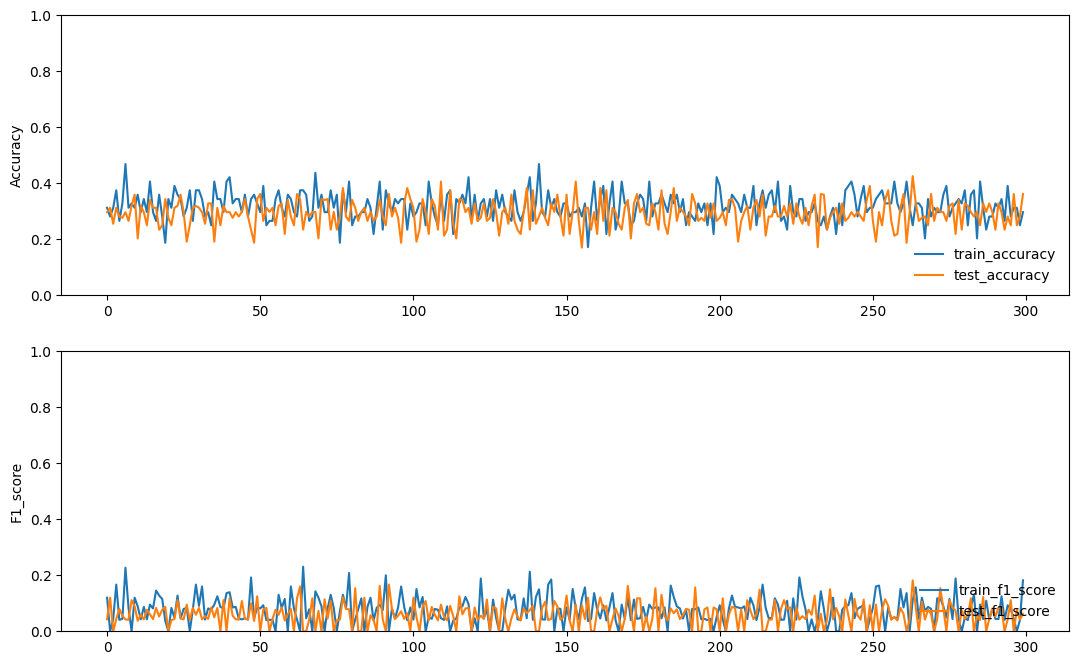

In [ ]:
## changing learning rate (fixed 0.000001)

model = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.000001) # Adam optimizer

## training the model
train_accuracy_values = []
test_accuracy_values = []
train_f1_values = []
test_f1_values = []

num_epochs = 100
for epoch in range(num_epochs):
    for (X_train, y_train), (X_test, y_test) in zip(train_dataloader, test_dataloader):
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss = criterion(pred_train, y_train.unsqueeze(-1)) # compute loss
        loss.backward()
        optimizer.step()

        # compute training accuracy and F1-score at this epoch
        pred_train = (model(X_train) > 0.5).float()
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1 = f1_score(y_train, pred_train)
        train_accuracy_values.append(train_accuracy)
        train_f1_values.append(train_f1)

        # compute testing accuracy and F1-score at this epoch
        pred_test = (model(X_test) > 0.5).float()
        test_accuracy = accuracy_score(y_test, pred_test)
        test_f1 = f1_score(y_test, pred_test)
        test_accuracy_values.append(test_accuracy)
        test_f1_values.append(test_f1)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training F1 Score: {train_f1:.4f}")
print(f"Final Testing F1 Score: {test_f1:.4f}")

# plotting training and test performances over epochs
fig, axs = plt.subplots(2, 1, figsize=(13,8))
axs[0].plot(train_accuracy_values, label='train_accuracy')
axs[0].plot(test_accuracy_values, label='test_accuracy')
axs[0].legend(frameon=False, loc='lower right')
axs[0].set_ylim([0, 1])
axs[0].set_ylabel('Accuracy')
###
axs[1].plot(train_f1_values, label='train_f1_score')
axs[1].plot(test_f1_values, label='test_f1_score')
axs[1].legend(frameon=False, loc='lower right')
axs[1].set_ylim([0, 1])
axs[1].set_ylabel('F1_score')

The learning rate is a crucial hyperparameter in training machine learning models, and its choice can significantly impact the model's performance. Comparing the results of learning rate = 0.1 and learning rate=0.000001 shows the significant difference between the training and testing accuracies. The learning rate= 0.000001 has much lower training and testing accuracies compared with the lr = 0.1.

Small Learning Rate:

Effects:
Stability: Small learning rates lead to more stable training, as they make smaller updates to the model weights at each iteration.
Convergence:They often result in smoother convergence, allowing the model to gradually approach the optimal solution.

Advantages:
Precision: Small learning rates can help the model to fine-tune its parameters with precision, especially in complex or noisy datasets.
Avoiding Overshooting: They are less likely to cause the model to overshoot the minimum and potentially converge to a better solution.

Disadvantages:
Slow Convergence: Training with a small learning rate can be computationally expensive and time-consuming, as the model makes tiny adjustments to the weights.
Getting Stuck in Local Minima: The slow progress might cause the model to get stuck in local minima and struggle to escape.

Large Learning Rate:

Effects:
Fast Convergence: Large learning rates result in quicker convergence, as the model makes larger updates to the weights.
Risk of Overshooting: There's a higher risk of overshooting the minimum and oscillating around it, potentially causing the model to fail to converge.

Advantages:
Quick Exploration: Large learning rates allow the model to explore the parameter space more quickly, which can be beneficial in certain situations.
Escape from Saddle Points: They can help the model escape from saddle points, which are regions where the gradient is near zero in some dimensions.

Disadvantages:
Instability: Large learning rates can lead to instability during training, causing the loss function to oscillate or diverge.
Missing the Minimum: The model may skip the optimal solution if the learning rate is too large, as it might overshoot the minimum.


5 c continued : Applying learning rate scheduler

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Final Training Accuracy: 0.6562
Final Testing Accuracy: 0.6170
Final Training F1 Score: 0.7755
Final Testing F1 Score: 0.7097


Text(0, 0.5, 'F1_score')

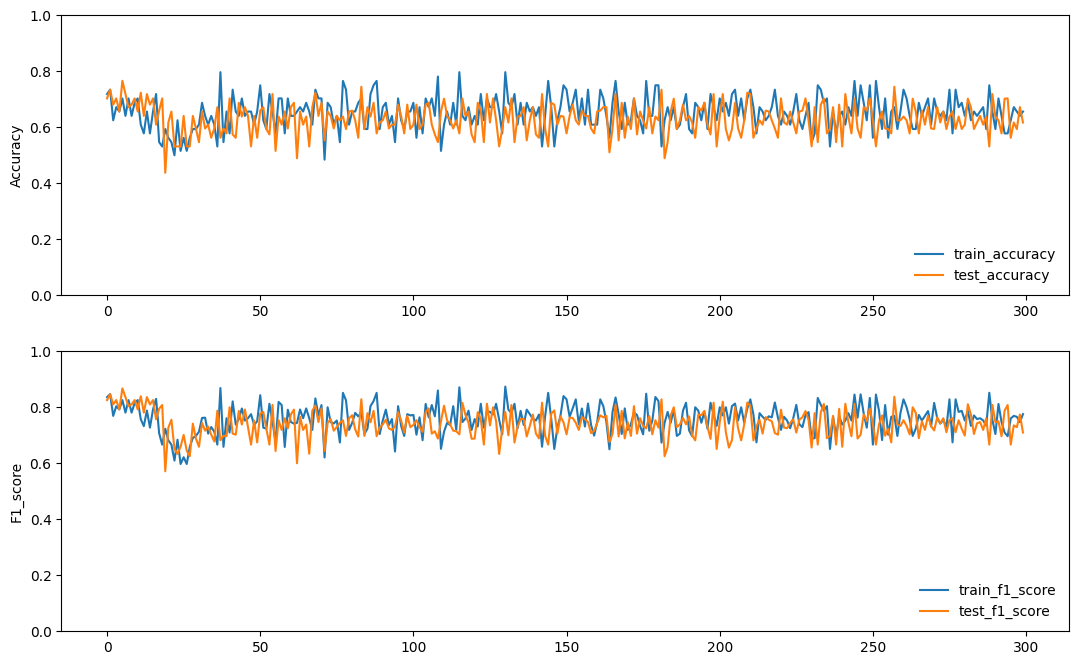

In [ ]:
## changing learning rate (adaptive learning rate)
model = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)  # scheduler

## training the model
train_accuracy_values = []
test_accuracy_values = []
train_f1_values = []
test_f1_values = []

num_epochs = 100
for epoch in range(num_epochs):
    for (X_train, y_train), (X_test, y_test) in zip(train_dataloader, test_dataloader):
        # update learning rate using the scheduler
        scheduler.step()

        optimizer.zero_grad()
        pred_train = model(X_train)
        loss = criterion(pred_train, y_train.unsqueeze(-1)) # compute loss
        loss.backward()
        optimizer.step()

        # compute training accuracy and F1-score at this epoch
        pred_train = (model(X_train) > 0.5).float()
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1 = f1_score(y_train, pred_train)
        train_accuracy_values.append(train_accuracy)
        train_f1_values.append(train_f1)

        # compute testing accuracy and F1-score at this epoch
        pred_test = (model(X_test) > 0.5).float()
        test_accuracy = accuracy_score(y_test, pred_test)
        test_f1 = f1_score(y_test, pred_test)
        test_accuracy_values.append(test_accuracy)
        test_f1_values.append(test_f1)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training F1 Score: {train_f1:.4f}")
print(f"Final Testing F1 Score: {test_f1:.4f}")

# plotting training and test performances over epochs
fig, axs = plt.subplots(2, 1, figsize=(13,8))
axs[0].plot(train_accuracy_values, label='train_accuracy')
axs[0].plot(test_accuracy_values, label='test_accuracy')
axs[0].legend(frameon=False, loc='lower right')
axs[0].set_ylim([0, 1])
axs[0].set_ylabel('Accuracy')
###
axs[1].plot(train_f1_values, label='train_f1_score')
axs[1].plot(test_f1_values, label='test_f1_score')
axs[1].legend(frameon=False, loc='lower right')
axs[1].set_ylim([0, 1])
axs[1].set_ylabel('F1_score')

Comparison between Fixed rate learning rate and learning rate scheduler:
Fixed Learning Rate:
In a fixed learning rate approach, the learning rate remains constant throughout the training process.

Advantages:
Simplicity: Fixed learning rates are easy to implement and understand. There is no need for additional complexity in the learning rate adjustment logic. Stability: They can provide stability during training, especially when dealing with simple models or datasets with smooth loss landscapes.

Disadvantages:
Suboptimal Performance: A fixed learning rate may lead to suboptimal performance, especially when dealing with complex models or non-uniformly distributed data.
Limited Adaptability: It lacks adaptability to changes in the training dynamics. If the model encounters regions of the parameter space where the gradients vary widely, a fixed learning rate may be too aggressive or too conservative.

Learning Rate Scheduler:
A learning rate scheduler dynamically adjusts the learning rate during training based on a predefined schedule. Common schedules include step decay, exponential decay, and cosine annealing.

Advantages:
Adaptability: Learning rate schedulers adapt the learning rate according to the training progress. This can be beneficial in overcoming challenges like plateauing or overshooting during different stages of training.
Improved Performance: Dynamic adjustments can lead to improved model convergence and better generalization, especially when dealing with non-stationary or noisy data.

Disadvantages:
Complexity: Learning rate schedulers introduce an additional layer of complexity to the training process, requiring careful tuning of parameters and potential increases in computational cost.
Task-Specific Tuning: The scheduler's performance may depend on task-specific characteristics, and finding the optimal schedule might require experimentation.

Choosing Between Them:

Fixed Learning Rate:
Suitable for simple models and datasets with relatively uniform characteristics.
Quick to implement and less prone to overfitting the learning rate schedule to the training dataset.
Learning Rate Scheduler:
Preferred for complex models and non-uniform data distributions.
Offers better adaptability to changes in the loss landscape during training.
Requires more careful tuning but can lead to better overall performance.

In practice, a combination of both approaches is sometimes used. For instance, starting with a relatively high learning rate and then applying a learning rate scheduler as training progresses can harness the benefits of both stable initial convergence and adaptive adjustments during later stages. Leaning rate scheduler is the chosen model.

5. d balancing the training dataset

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Final Training Accuracy: 0.7500
Final Testing Accuracy: 0.7872
Final Training F1 Score: 0.8261
Final Testing F1 Score: 0.8718


Text(0, 0.5, 'F1_score')

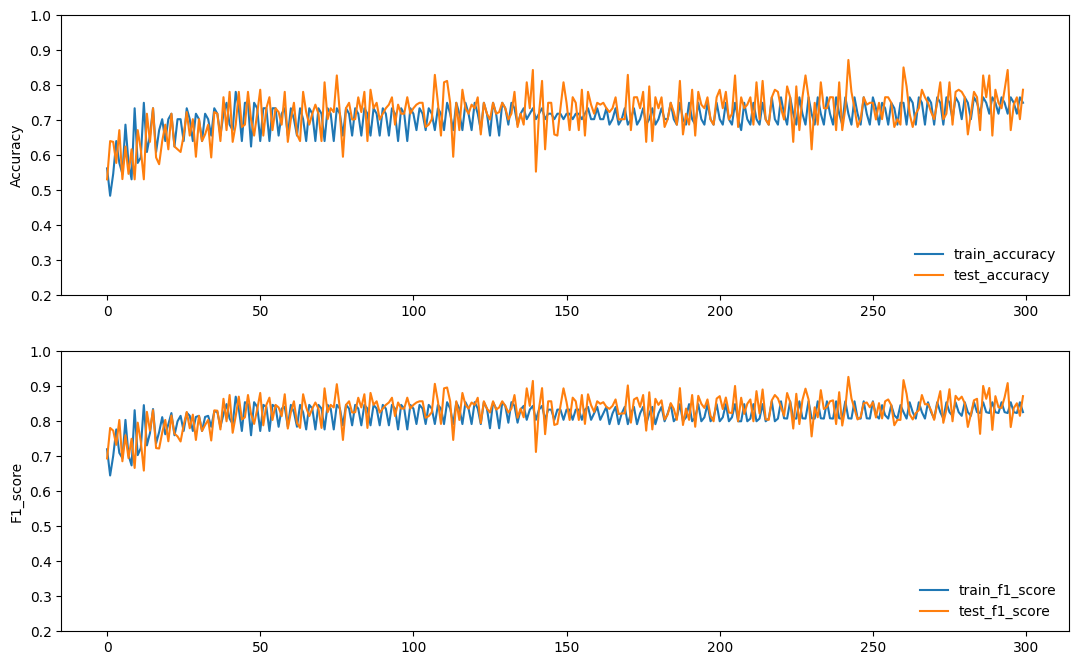

In [ ]:
# with oversampling
oversampler = RandomOverSampler(sampling_strategy='auto')
X_train, X_test, y_train, y_test, group_train, group_test = sklearn.model_selection.train_test_split(features,
                                                                            labels, group, test_size=0.3,
                                                                            train_size=0.7, shuffle = True,
                                                                            random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
train_data = Data(X_train_resampled, y_train_resampled)
train_dataloader = DataLoader(train_data, batch_size=batch_size)


model = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

## training the model
train_accuracy_values = []
test_accuracy_values = []
train_f1_values = []
test_f1_values = []

num_epochs = 100
for epoch in range(num_epochs):
    for (X_train, y_train), (X_test, y_test) in zip(train_dataloader, test_dataloader):
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss = criterion(pred_train, y_train.unsqueeze(-1)) # compute loss
        loss.backward()
        optimizer.step()

        # compute training accuracy and F1-score at this epoch
        pred_train = (model(X_train) > 0.5).float()
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1 = f1_score(y_train, pred_train)
        train_accuracy_values.append(train_accuracy)
        train_f1_values.append(train_f1)

        # compute testing accuracy and F1-score at this epoch
        pred_test = (model(X_test) > 0.5).float()
        test_accuracy = accuracy_score(y_test, pred_test)
        test_f1 = f1_score(y_test, pred_test)
        test_accuracy_values.append(test_accuracy)
        test_f1_values.append(test_f1)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training F1 Score: {train_f1:.4f}")
print(f"Final Testing F1 Score: {test_f1:.4f}")

# plotting training and test performances over epochs
fig, axs = plt.subplots(2, 1, figsize=(13,8))
axs[0].plot(train_accuracy_values, label='train_accuracy')
axs[0].plot(test_accuracy_values, label='test_accuracy')
axs[0].legend(frameon=False, loc='lower right')
axs[0].set_ylim([0.2, 1])
axs[0].set_ylabel('Accuracy')
###
axs[1].plot(train_f1_values, label='train_f1_score')
axs[1].plot(test_f1_values, label='test_f1_score')
axs[1].legend(frameon=False, loc='lower right')
axs[1].set_ylim([0.2, 1])
axs[1].set_ylabel('F1_score')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Final Training Accuracy: 0.3594
Final Testing Accuracy: 0.4894
Final Training F1 Score: 0.5287
Final Testing F1 Score: 0.4000


Text(0, 0.5, 'F1_score')

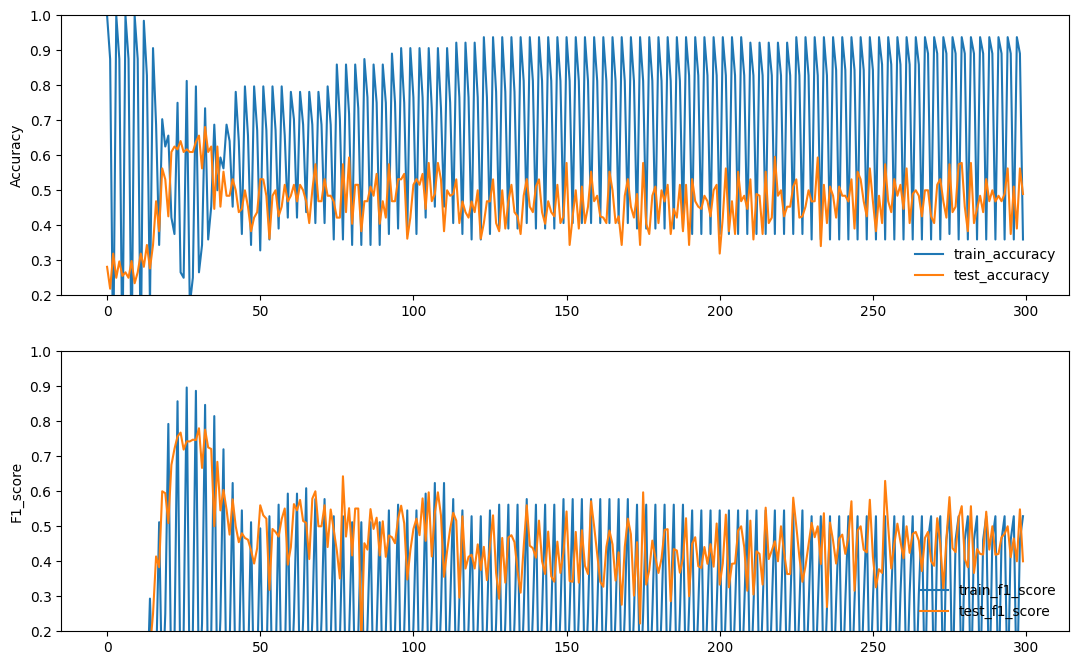

In [ ]:
# with undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto')
X_train, X_test, y_train, y_test, group_train, group_test = sklearn.model_selection.train_test_split(features,
                                                                            labels, group, test_size=0.3,
                                                                            train_size=0.7, shuffle = True,
                                                                            random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
train_data = Data(X_train_resampled, y_train_resampled)
train_dataloader = DataLoader(train_data, batch_size=batch_size)


model = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

## training the model
train_accuracy_values = []
test_accuracy_values = []
train_f1_values = []
test_f1_values = []

num_epochs = 100
for epoch in range(num_epochs):
    for (X_train, y_train), (X_test, y_test) in zip(train_dataloader, test_dataloader):
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss = criterion(pred_train, y_train.unsqueeze(-1)) # compute loss
        loss.backward()
        optimizer.step()

        # compute training accuracy and F1-score at this epoch
        pred_train = (model(X_train) > 0.5).float()
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1 = f1_score(y_train, pred_train)
        train_accuracy_values.append(train_accuracy)
        train_f1_values.append(train_f1)

        # compute testing accuracy and F1-score at this epoch
        pred_test = (model(X_test) > 0.5).float()
        test_accuracy = accuracy_score(y_test, pred_test)
        test_f1 = f1_score(y_test, pred_test)
        test_accuracy_values.append(test_accuracy)
        test_f1_values.append(test_f1)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training F1 Score: {train_f1:.4f}")
print(f"Final Testing F1 Score: {test_f1:.4f}")

# plotting training and test performances over epochs
fig, axs = plt.subplots(2, 1, figsize=(13,8))
axs[0].plot(train_accuracy_values, label='train_accuracy')
axs[0].plot(test_accuracy_values, label='test_accuracy')
axs[0].legend(frameon=False, loc='lower right')
axs[0].set_ylim([0.2, 1])
axs[0].set_ylabel('Accuracy')
###
axs[1].plot(train_f1_values, label='train_f1_score')
axs[1].plot(test_f1_values, label='test_f1_score')
axs[1].legend(frameon=False, loc='lower right')
axs[1].set_ylim([0.2, 1])
axs[1].set_ylabel('F1_score')

Comparing the applied oversampling and undersampling techniques in the assignment shows that with Oversampling method we got much higher training and testing accuracies of 0.75 and 0.78 respectively. While with undersampling we got training and testing accuracies of 0.35 and 0.48 respectively which are remarkably lower than the results with oversampling method.

Undersampling and oversampling are two techniques used in handling imbalanced datasets such as the liver patient dataset we used in this assignment.

Undersampling:
Definition:
Undersampling involves reducing the number of instances in the majority class to balance the class distribution. This is typically done by randomly removing instances from the majority class.

Advantages:
Computationally Efficient: Undersampling reduces the size of the dataset, making it computationally more efficient compared to oversampling.
Reduced Model Bias: By balancing the class distribution, undersampling helps prevent the model from being biased towards the majority class.

Disadvantages:
Information Loss: Removing instances from the majority class may result in the loss of valuable information, especially if the dataset is small to begin with.
Increased Variability: Undersampling may lead to increased variability in the training process due to the reduced number of instances available for learning.

Oversampling:
Oversampling involves increasing the number of instances in the minority class to balance the class distribution. This is typically done by duplicating or generating synthetic instances.

Advantages:
Preservation of Information: Oversampling helps in preserving information from the minority class, reducing the risk of information loss.
Better Model Generalization: A balanced dataset often leads to better model generalization, especially in cases where the minority class is important.

Disadvantages:
Increased Computational Cost: Generating synthetic instances or duplicating data can increase the computational cost of training, especially for large datasets.
Risk of Overfitting: If not done carefully, oversampling can lead to overfitting, as the model may become too familiar with the minority class instances.

Effectiveness on the Training Process:

Undersampling:
Effective when the majority class has a sufficient number of instances and the dataset is large.
May not perform well when the dataset is small or when important information is lost during the undersampling process.

Oversampling:
Effective when the minority class is underrepresented and needs more instances for the model to learn its characteristics.
Can be prone to overfitting if not used cautiously, especially if synthetic instances are generated.

Combined Approach:
In some cases, a combination of both undersampling and oversampling techniques, known as hybrid sampling, may be employed to strike a balance between addressing class imbalance and preserving information.

The choice between undersampling and oversampling depends on factors such as the dataset size, the importance of information in the majority class, and the computational resources available. Experimentation and careful evaluation are crucial to determine which technique or combination of techniques works best for a specific problem.

5.e showing decision boundries

Text(0, 0.5, 'Albumin')

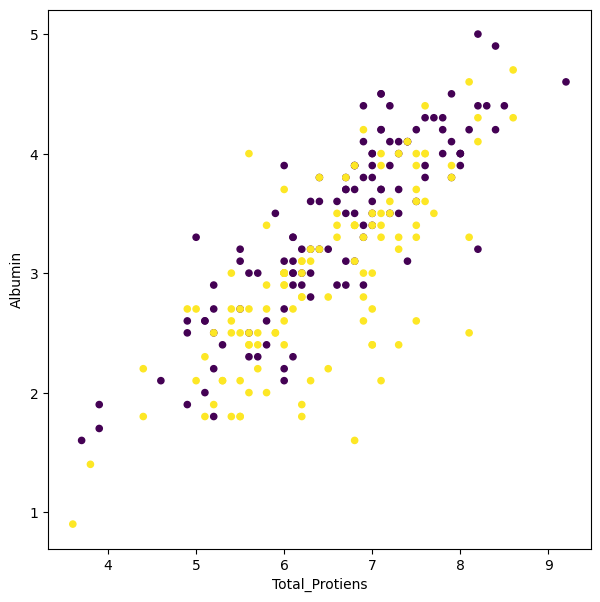

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_train_resampled[:, 7], X_train_resampled[:, 8],
          s=20, c=y_train_resampled, label=y_train_resampled)
ax.set_xlabel('Total_Protiens')
ax.set_ylabel('Albumin')

the best two features that separate two classes were albumin and total protein measurements in liver patient. Yellow color data are the healthy patients and dark purple data are the liver patients. the goal is to separate these two features with a line but these two sets of data are highly correlated and is too difficult to make these separated. this is called multicolinearity which is a difficult concept to solve in machine learning algorithms. To note that albumin is a protein and the correlation is in line with total protein as well which clinically agrees with the results. And the high correlation between these two features explain the low accuracy too.

To plot the boundary line between the multicolinear features:

In [ ]:
from torch.autograd import Variable

def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset[:, 7].min() - 1, dataset[:, 7].max() + 1 # index 7 is total protein
    ymin, ymax = dataset[:, 8].min() - 1, dataset[:, 8].max() + 1 # index 8 is Albumin
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

    # Plot decision boundary in region of interest
    labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels_predicted = model(dataset)
    ax.scatter(dataset[:, 7], dataset[:, 8], c=labels.reshape(labels.size()[0]), cmap=color_map, lw=0)
    plt.show()
    return fig, ax